In [80]:
from datetime import datetime
import math
import sqlite3
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
database_filepath = '../data/resstock.sql'
con = sqlite3.connect(database_filepath)

In [3]:
building_ids = pd.read_sql("SELECT DISTINCT bldg_id FROM building_timeseries",con)['bldg_id'].tolist()

In [4]:
building_timeseries_normalize_query = lambda building_id, variable: f"""
SELECT
    t.bldg_id AS building_id,
    t.timestamp,
    DATE(t.timestamp) AS date,
    CAST(strftime('%H', t.timestamp) AS INTEGER) AS hour,
    CAST(strftime('%H:%M', t.timestamp) AS TEXT) AS time,
    (t.{variable} - b.minimum) / (b.maximum - b.minimum) AS normalized_value
FROM building_timeseries t
LEFT JOIN (
    SELECT
        bldg_id,
        MIN({variable}) AS minimum,
        MAX({variable}) AS maximum
    FROM building_timeseries
    WHERE bldg_id = {building_id}
    GROUP BY
        bldg_id
) b ON b.bldg_id = t.bldg_id
WHERE t.bldg_id = {building_id}
"""

Completed 1020/1020 (100.0%)


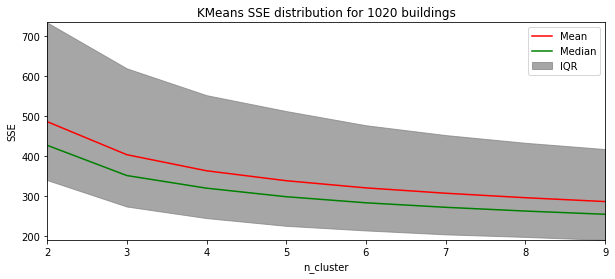

In [14]:
# KMeans clustering of profiles
# Find out the distribution of ideal k for each building_id
n_clusters = list(range(2,10))
sse_record_list = []
label_data_list = []
n_cluster_data_list = []

for i, building_id in enumerate(building_ids):
    query = building_timeseries_normalize_query(building_id,'out_electricity_plug_loads_energy_consumption')
    data = pd.read_sql(query,con)
    data = data.pivot(index='date',columns='time',values='normalized_value')
    data = data.dropna()
    x = data[data.columns.tolist()].copy()

    for n_cluster in n_clusters:
        model = KMeans(n_clusters=n_cluster,random_state=0).fit(x)
        sse_record_list.append({'building_id':building_id,'n_cluster':n_cluster,'sse':model.inertia_})
        n_cluster_data = data.copy()
        n_cluster_data['label'] = model.labels_
        label_data = n_cluster_data[['label']].reset_index(drop=False).copy()
        label_data['building_id'] = building_id
        label_data['n_cluster'] = n_cluster
        label_data_list.append(label_data)
        n_cluster_data = n_cluster_data.groupby('label').describe().reset_index(drop=False)
        n_cluster_data['building_id'] = building_id
        n_cluster_data['n_cluster'] = n_cluster
        n_cluster_data_list.append(n_cluster_data)
        
    print(f'\rCompleted {i+1}/{len(building_ids)} ({round((i+1)*100/len(building_ids),1)}%)',end="")

print()
sse_data = pd.DataFrame(sse_record_list)
plot_data = sse_data.groupby(['n_cluster'])[['sse']].describe()
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.margins(0)
ax.plot(plot_data.index,plot_data[('sse','mean')],color='red',label='Mean')
ax.plot(plot_data.index,plot_data[('sse','50%')],color='green',label='Median')
ax.fill_between(plot_data.index,plot_data[('sse','25%')],plot_data[('sse','75%')],color='grey',alpha=0.7,label='IQR')
ax.set_xlabel('n_cluster')
ax.set_ylabel('SSE')
ax.set_title(f'KMeans SSE distribution for {len(building_ids)} buildings')
ax.legend()
plt.show()

In [111]:
n_cluster = 3
# n_cluster_data = pd.concat(n_cluster_data_list,ignore_index=True)
n_cluster_data = n_cluster_data[n_cluster_data['n_cluster']==n_cluster].copy()

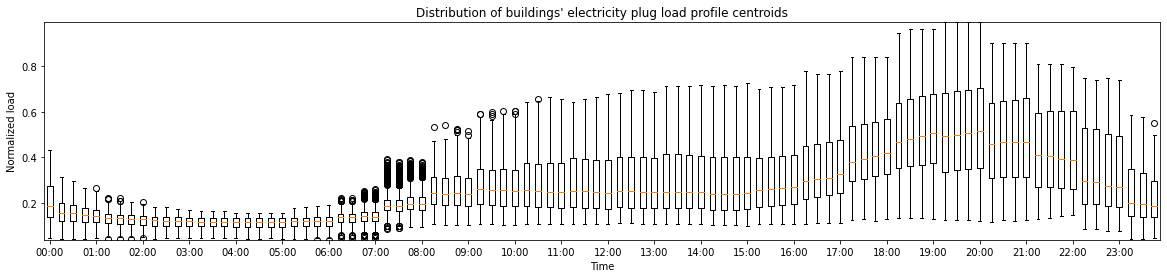

In [112]:
# distribution of load profile centroids
plot_data = n_cluster_data.copy()
time_columns = [(time,'mean') for time in sorted(set(plot_data.columns.get_level_values(0)[1:-4]))]
plot_data = plot_data[time_columns + [('building_id',''),('label','')]]
fig, ax = plt.subplots(1,1,figsize=(20,4))
ax.boxplot(plot_data[time_columns].values)
ax.set_title('Distribution of buildings\' electricity plug load profile centroids')
xticks = [i for i in range(1,len(time_columns),4)]
ax.set_xticks(xticks)
ax.set_xticklabels([time_columns[i-1][0] for i in xticks])
ax.set_xlabel('Time')
ax.set_ylabel('Normalized load')
ax.margins(0,0)
plt.show()

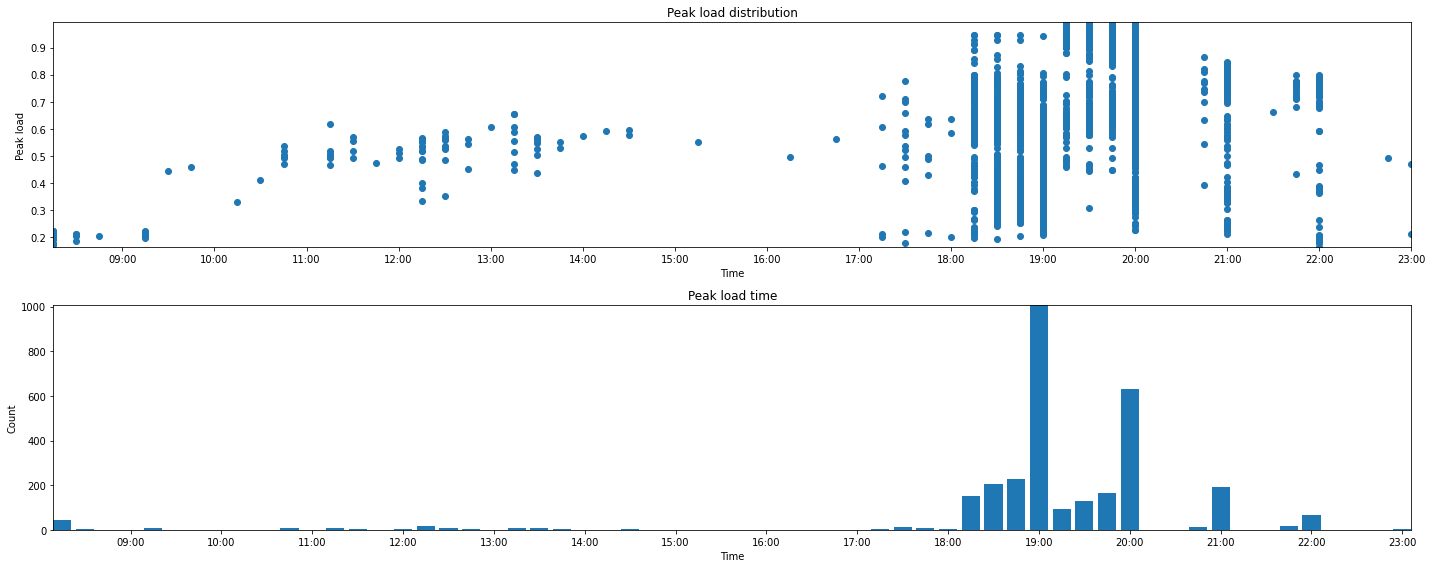

In [113]:
# distribution of peak load time
plot_data = n_cluster_data.copy()
time_columns = [(time,'mean') for time in sorted(set(plot_data.columns.get_level_values(0)[1:-4]))]
plot_data = plot_data[time_columns + [('building_id',''),('label','')]]
plot_data.columns = plot_data.columns.get_level_values(0)
plot_data = plot_data.melt(
    id_vars=['building_id','label'],
    value_vars=plot_data.columns.tolist()[0:-2]
)
plot_data['time'] = plot_data['time'].map(lambda x: datetime.strptime(x,'%H:%M'))
times = plot_data[['time']].drop_duplicates().sort_values('time').reset_index(drop=True)
times['ix'] = times.index
plot_data = plot_data.loc[plot_data.groupby(['building_id','label'])['value'].idxmax()].copy()
fig, axs = plt.subplots(2,1,figsize=(20,8))
axs[0].scatter(plot_data['time'],plot_data['value'])
axs[0].xaxis.set_major_locator(mdates.HourLocator())
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[0].set_title('Peak load distribution')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Peak load')
axs[0].margins(0)

plot_data = plot_data.groupby('time').size().reset_index(name='count').sort_values('time')
plot_data = pd.merge(plot_data,times,on='time',how='right').sort_values('ix')
axs[1].bar(plot_data['ix'],plot_data['count'])
axs[1].set_title('Peak load time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Count')
xticks = [i for i in range(0,len(plot_data),4)]
axs[1].set_xticks(xticks)
axs[1].set_xticklabels([time.strftime('%H:%M') for time in plot_data.iloc[xticks]['time']])
axs[1].margins(0)
plt.tight_layout()
plt.show()

In [115]:
# centroid
plot_data = n_cluster_data.copy()
time_columns = [(time,'mean') for time in sorted(set(plot_data.columns.get_level_values(0)[1:-4]))]
plot_data = plot_data[time_columns + [('building_id',''),('label','')]]
plot_data.columns = plot_data.columns.get_level_values(0)
plot_data = plot_data.melt(
    id_vars=['building_id','label'],
    value_vars=plot_data.columns.tolist()[0:-2]
).sort_values('time')
# plot_data = plot_data[plot_data['building_id'].isin(building_ids[0:10])].copy()
plot_data['time'] = plot_data['time'].map(lambda x: datetime.strptime(x,'%H:%M'))
ax_size = (4,2.5)
column_count_limit = 8
row_count = math.ceil(len(plot_data['building_id'].unique())/column_count_limit)
fig, axs = plt.subplots(
    row_count,
    column_count_limit,
    figsize=(ax_size[0]*column_count_limit,ax_size[1]*row_count),
)
cluster_colors = ['red','orange','green','blue','indigo','violet']

for ax, (building_id, building_group) in zip(fig.axes, plot_data.groupby('building_id')):
    for i, (label, label_group) in enumerate(building_group.groupby('label')):
        x = label_group['time']
        y = label_group['value']
        ax.plot(x,y,label=label,clip_on=False,color=cluster_colors[i],linewidth=3)
        ax.margins(0)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax.set_title(building_id,fontsize=20)
        ax.set_ylim(0,1)
        ax.axis('off')

plt.tight_layout()
plt.savefig('electricity_plug_loads_energy_consumption_daily_profile_centroid.pdf',transparent=True,bbox_inches='tight')
plt.close()

In [78]:
# n_cluster_data = pd.concat(n_cluster_data_list,ignore_index=True)
# n_cluster_data.to_pickle('n_cluster.pkl')
# label_data = pd.concat(label_data_list,ignore_index=True)
# label_data.to_pickle('label.pkl')
# sse_data.to_pickle('sse.pkl')

In [110]:
n_cluster_data = pd.read_pickle('n_cluster.pkl')
label_data = pd.read_pickle('label.pkl')
sse_data = pd.read_pickle('sse.pkl')